# Final Project
Kaloyan Boychev

(discleimer: parts of the final project have been insipered by an old project of mine in a previous course namely (Text Retrival nad Mining). The main parts insiper are idea for the data and the preproccessed spacy docs file which is use for speed pourposes)

# The data
This is a reusable publicly-available dataset for “media bias” studies. The content of this dataset is publish date, title, subtitle and text for 3824 news articles. These articles are collected by a project within 3 months from December of 2016 to march 2017. The source of these news articles are from ABC News, CNN news, The Huffington Post, BBC News, DW News, TASS News, Al Jazeera News, China Daily and RTE News. All of them are collected by using RSS feeds of each news sites

In [40]:
import pandas as pd
import requests
import spacy
from spacy.tokens import DocBin

In [41]:
r = requests.get("https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/GMFCTR/IZQODZ")
assert r.status_code == 200
with open("NewsArticles.csv", "wb") as out:
    out.write(r.content)


In [42]:
dataframe = pd.read_csv('NewsArticles.csv', encoding='latin1')
df = dataframe[['publish_date', 'text']].copy().dropna().reset_index(drop=True)
df["publish_date"] = df["publish_date"].str.strip()

# Attempt to convert and flag problematic rows
df["valid_date"] = pd.to_datetime(df["publish_date"], errors='coerce')

# Replace problematic rows with the value from the previous row
df["publish_date"] = df["publish_date"].where(df["valid_date"].notna(), None)
df["publish_date"] = df["publish_date"].fillna(method='ffill')  # Forward-fill problematic rows

# Drop the helper column
df = df.drop(columns=["valid_date"])

# Convert the publish_date column after replacing problematic values
df["publish_date"] = pd.to_datetime(df["publish_date"])


<ipython-input-42-3cb0550ab696>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["publish_date"] = df["publish_date"].fillna(method='ffill')  # Forward-fill problematic rows


In [43]:
### We begin with quick EDA of the data:
print("Shape of the data")
print(df.shape)

print("Data")
print(df.head())


Shape of the data
(3791, 2)
Data
  publish_date                                               text
0   2017-02-07  Michigan billionaire education activist Betsy ...
1   2017-02-07  First lady Melania Trump has said little about...
2   2017-02-07  A House committee voted on Tuesday to eliminat...
3   2017-02-07  This afternoon, three federal judges from the ...
4   2017-02-07  At least four tornadoes touched down in Louisi...


In [44]:
import spacy
from spacy.tokens import DocBin

r = requests.get("https://surfdrive.surf.nl/files/index.php/s/dMG8AbWWcUpiq4a/download")
assert r.status_code == 200
with open("docs.spacy", "wb") as out:
    out.write(r.content)

en = spacy.load("en_core_web_sm")
doc_bin = DocBin().from_disk("docs.spacy")
df["spacy_doc"] = list(doc_bin.get_docs(vocab=en.vocab))


In [45]:
df.head()

,publish_date,text,spacy_doc
0,2017-02-07,Michigan billionaire education activist Betsy ...,"(Michigan, billionaire, education, activist, B..."
1,2017-02-07,First lady Melania Trump has said little about...,"(First, lady, Melania, Trump, has, said, littl..."
2,2017-02-07,A House committee voted on Tuesday to eliminat...,"(A, House, committee, voted, on, Tuesday, to, ..."
3,2017-02-07,"This afternoon, three federal judges from the ...","(This, afternoon, ,, three, federal, judges, f..."
4,2017-02-07,At least four tornadoes touched down in Louisi...,"(At, least, four, tornadoes, touched, down, in..."


First we want to analyze the data to see what we are working with


Number of Articles Published Per Year:
publish_date
2016     131
2017    3660
dtype: int64
Number of Words Per Article:


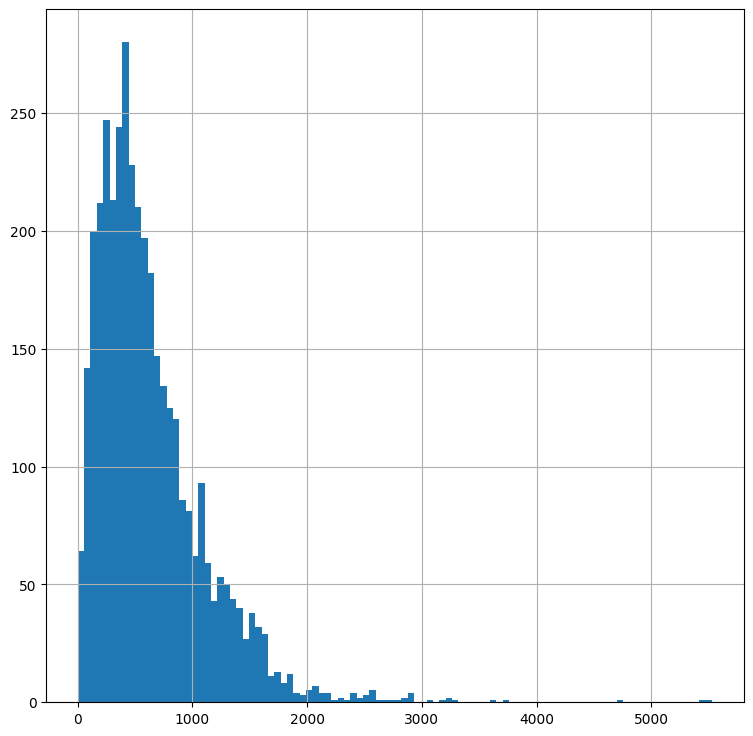

In [46]:
# We want to analyze the number of articles per year:
print("Number of Articles Published Per Year:")
print(df.groupby(df["publish_date"].dt.year).size())

# We will count all the words in each of the articles adn plot them to visually see the trands
df["nb_words"] = df["spacy_doc"].apply(len)
print("Number of Words Per Article:")
_ = df['nb_words'].hist(bins=100, figsize=(9, 9))

# Text Mining
In this section, we apply the concept of Text Mining, a key technique in Natural Language Processing (NLP), to analyze the textual data from newsletters. The primary goal is to identify and categorize each word in the text according to its grammatical role, such as nouns, verbs, pronouns, and other parts of speech (POS). This enables a deeper understanding of the linguistic structure and thematic focus of the text.

To achieve this, we utilize SpaCy, a widely used NLP library, known for its efficiency and accuracy in text processing tasks. SpaCy provides built-in capabilities for lemmatization and POS tagging, which form the core of this analysis.

1.   **Lemmatization:** SpaCy’s lemmatizer is employed to convert each wordinto its base or dictionary form, known as its lemma. This process normalizes the text by reducing variations such as plural forms and verb inflections to their root forms. For instance, "running" is lemmatized to "run," and "dogs" is lemmatized to "dog." The lemmatization step ensures that different forms of the same word are treated as a single entity, thereby simplifying the analysis. The lemmas are standardized to lowercase to maintain consistency.
2.  **POS Tagging:** Using SpaCy’s linguistic models, each word is assigned a POS tag that specifies its grammatical function, such as noun, verb, pronoun, adjective, etc. This tagging is context-sensitive, allowing SpaCy to accurately determine the role of a word even when its usage varies depending on the sentence.

The output of this analysis, consisting of lemmas and their corresponding POS tags, is organized into a structured data frame. This makes it easier to conduct further analysis, such as filtering and aggregating specific grammatical categories.

3.   **Frequency Analysis:** Once the text has been lemmatized and tagged, we analyze the frequency of specific parts of speech. Using SpaCy’s tokenization and attribute-based querying capabilities, we extract the top five most frequent nouns, verbs, and pronouns across the dataset. This provides insights into the dominant themes and actions described in the text, as well as the most commonly referenced entities.






In [47]:
from collections import defaultdict, Counter

pos = []

for doc in df["spacy_doc"]:
    for token in doc:
        pos.append({"pos": token.pos_, "lemma": token.lemma_.lower()})

pos_df = pd.DataFrame(pos)
print(pos_df.shape)
print(pos_df.head())
print(pos_df["pos"].value_counts())


(2393052, 2)
     pos        lemma
0  PROPN     michigan
1   NOUN  billionaire
2   NOUN    education
3   NOUN     activist
4  PROPN        betsy
pos
NOUN     443415
PUNCT    290784
VERB     257371
ADP      253286
PROPN    249005
DET      201842
ADJ      158922
PRON     126640
AUX      115367
ADV       73154
PART      68039
CCONJ     62581
NUM       44236
SCONJ     39756
SYM        3049
SPACE      2869
X          1837
INTJ        899
Name: count, dtype: int64


In [48]:
### Here we are lookign at the top 5 Nouns, Verbs and Pronouns
print("Top 5 Nouns")
print(pos_df[pos_df["pos"] == "NOUN"]["lemma"].value_counts().head(5))
print("Top 5 Verbs")
print(pos_df[pos_df["pos"] == "VERB"]["lemma"].value_counts().head(5))
print("Top 5 Pronouns")
print(pos_df[pos_df["pos"] == "PRON"]["lemma"].value_counts().head(5))

Top 5 Nouns
lemma
year          6373
people        4709
country       3997
time          3217
government    3138
Name: count, dtype: int64
Top 5 Verbs
lemma
say     19393
have     6955
make     4142
take     3499
tell     3167
Name: count, dtype: int64
Top 5 Pronouns
lemma
it      14704
he      14338
they     8940
that     8841
we       8250
Name: count, dtype: int64


In [49]:
### Here we will take the top three verbs and see what different pos tags were they given
print('say')
print(pos_df[pos_df["lemma"] == "say"]["pos"].value_counts())
print('have')
print(pos_df[pos_df["lemma"] == "have"]["pos"].value_counts())
print('make')
print(pos_df[pos_df["lemma"] == "make"]["pos"].value_counts())



say
pos
VERB     19393
NOUN        24
INTJ        10
PROPN        4
Name: count, dtype: int64
have
pos
AUX     18963
VERB     6955
NOUN        1
Name: count, dtype: int64
make
pos
VERB     4142
NOUN        9
PROPN       3
Name: count, dtype: int64


In this stage of the analysis, we focus on pronouns and their relationship with verbs. Using SpaCy’s POS tagging and dependency parsing, we extract tokens that meet the following criteria:


1.   The token's POS tag is 'PRON' (pronoun).
2.   The lemma of the token matches one of the subject pronouns: ["I", "you", "he", "she", "we", "they"]
3.   The pronoun functions as the subject of a verb, identified through SpaCy’s syntactic dependency parser (e.g., dependency type 'nsubj').



In [50]:
subj = []

for doc in df["spacy_doc"]:
    for token in doc:
        if token.pos_ == "PRON" and token.text.lower() in {"i", "you", "he", "she", "we", "you", "they"} and token.dep_ == "nsubj" and token.head.pos_ == "VERB":
            subj.append({"pronoun": token.text.lower(), "verb": token.head.lemma_.lower()})

subj_df = pd.DataFrame(subj)
print(subj_df.shape)
print(subj_df.head())
print(subj_df["pronoun"].value_counts())
print(subj_df["verb"].value_counts())



(33256, 2)
  pronoun        verb
0     she        read
1     she      attend
2     she       hedge
3    they     support
4     she  appreciate
pronoun
he      10365
we       6205
i        5635
they     5072
she      3125
you      2854
Name: count, dtype: int64
verb
say               3790
have              2444
think             1173
want              1149
know               814
                  ... 
fry                  1
scope                1
overhear             1
hungry?"?after       1
instance             1
Name: count, Length: 1583, dtype: int64


In [51]:
grps = subj_df.groupby(["pronoun", "verb"]).size().reset_index(name="count").sort_values(by=["pronoun", "count"], ascending=[True, False])
print(grps.groupby("pronoun").head(5).set_index(["pronoun", "verb"]))

               count
pronoun verb        
he      say     2543
        have     396
        add      392
        tell     281
        want     169
i       think    828
        have     362
        know     275
        want     258
        see      182
she     say      788
        have     123
        tell     111
        add       96
        want      59
they    have     368
        say      182
        want     174
        do       139
        get      114
we      have     783
        see      266
        want     253
        need     244
        do       216
you     have     412
        want     236
        know     169
        see      121
        need     115
